# Mujoco simulation of unitree z1

In [1]:
import mujoco
import mediapy as media
import numpy as np

%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


In [2]:
model = mujoco.MjModel.from_xml_path('scene.xml')
# model = mujoco.MjModel.from_xml_path('model/z1.urdf')
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

In [3]:
# save to xml when first load as urdf
# mujoco.mj_saveLastXML('model/z1.xml', model)

""

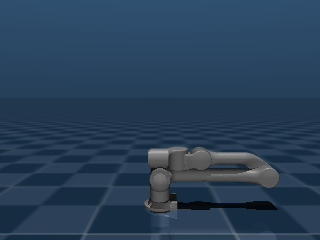

In [4]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [5]:
# check that we have 6 joints to control
data.ctrl

array([0., 0., 0., 0., 0., 0.])

## inverse dynamics control PTP

In [6]:
duration = 6  # (seconds)
framerate = 30

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

n_steps = int(np.ceil(duration * framerate)) + 1

sim_time = []
qpos = []
qvel = []
qacc = []
ctrl = []

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

target_q = np.array([np.pi / 4, np.pi / 4, -np.pi / 2, np.pi / 4, np.pi / 4, np.pi / 4])
kp = 100
kd = 15

while data.time < duration:
    # PD controller
    target_acc = kp * (target_q - data.qpos) + kd * (np.zeros(6) - data.qvel)

    # solve inverse dynamics
    prev = data.qacc
    data.qacc[:] = target_acc
    mujoco.mj_inverse(model, data)
    sol = data.qfrc_inverse

    data.ctrl[:] = sol
    data.qacc[:] = prev

    mujoco.mj_step(model, data)

    # save data
    sim_time.append(data.time)
    qpos.append(data.qpos)
    qvel.append(data.qvel)
    qacc.append(data.qacc)
    ctrl.append(data.ctrl)

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

## Load model to pinocchio

In [7]:
import pinocchio as pin
from pinocchio.utils import *
import numpy as np

model = pin.buildModelFromUrdf("z1.urdf")

## print dynamic parameters of each link

$ p = \begin{bmatrix} m & mx_c & my_c & mz_c & I_{xx} & I_{xy} &I_{yy} & I_{xz} &  I_{yz} & I_{zz} \end{bmatrix}^T $

In [8]:
with np.printoptions(precision=3, suppress=True):
    for i in range(len(model.inertias)):
        print(model.inertias[i].toDynamicParameters())

[ 0.472 -0.002 -0.     0.012  0.001 -0.     0.001  0.     0.     0.001]
[ 0.673  0.    -0.     0.016  0.002 -0.     0.001 -0.     0.     0.001]
[ 1.191 -0.131  0.003  0.002  0.001  0.001  0.039  0.    -0.     0.039]
[ 0.839  0.089 -0.005  0.029  0.002  0.     0.02  -0.005  0.     0.018]
[ 0.564  0.025  0.002 -0.001  0.    -0.     0.002  0.    -0.     0.002]
[ 0.389  0.012  0.     0.003  0.     0.     0.001 -0.    -0.     0.001]
[ 0.289  0.007 -0.    -0.     0.     0.     0.     0.     0.     0.   ]


### Example of computing joint torque regressor (no friction assumption)

In [9]:
A = []
b = []
for i, (t, q, v, a, tau) in enumerate(zip(sim_time, qpos, qvel, qacc, ctrl)):
    data = model.createData()
    res = pin.computeJointTorqueRegressor(model, data, q, v, a)

    for i in range(6):
        A.append(res[i])
        b.append(tau[i])

A = np.array(A)
b = np.array(b)

A.shape, b.shape

((18006, 60), (18006,))